# Using Computer Vision and Machine Learning to drive the Car

In [22]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt

import math
import json
import getpass

#import ML liberaries
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [23]:
var = getpass.getpass("Add driving direction:")

In [24]:
var

'2'

In [18]:
# Get the data from CSV file
data = pd.read_csv('data_output2024-01-03 20_51_53.508811.csv')


In [19]:
# get timestamp in the right format 
data['timestamp'] = data['timestamp'].str.replace('_', ':')
data['timestamp'] = pd.to_datetime(data['timestamp'], dayfirst=True)

# Create a column that counts the time in seconds since the laast frame
data['time-sec'] = (data['timestamp'] - data['timestamp'].shift(1)).dt.total_seconds().round(2)

In [20]:
data.head(20)

,motion,timestamp,i,LMR,model_prediction,img,time-sec
0,SlowForward,2024-01-03 20:51:23.078752,0,2,0,"[[86, 87, 91, 72, 89, 104, 107, 110, 117, 122,...",NaN
1,SlowForward,2024-01-03 20:51:23.526859,1,2,0,"[[92, 96, 97, 83, 94, 99, 104, 109, 113, 119, ...",0.45
2,SlowForward,2024-01-03 20:51:23.643797,2,2,0,"[[93, 96, 102, 86, 95, 98, 106, 111, 116, 122,...",0.12
3,SlowForward,2024-01-03 20:51:23.773899,3,2,0,"[[86, 90, 94, 80, 90, 100, 106, 110, 113, 121,...",0.13
4,SlowForward,2024-01-03 20:51:23.907948,4,2,0,"[[90, 92, 94, 79, 92, 99, 109, 112, 117, 119, ...",0.13
5,SlowForward,2024-01-03 20:51:24.038524,5,2,0,"[[92, 94, 96, 81, 93, 102, 108, 112, 115, 122,...",0.13
6,SlowForward,2024-01-03 20:51:24.172580,6,2,0,"[[89, 92, 92, 79, 89, 101, 104, 112, 117, 121,...",0.13
7,SlowForward,2024-01-03 20:51:24.308334,7,2,0,"[[92, 95, 95, 79, 93, 104, 106, 113, 117, 122,...",0.14
8,SlowForward,2024-01-03 20:51:24.441586,8,2,0,"[[90, 94, 94, 77, 94, 101, 105, 113, 118, 119,...",0.13
9,SlowForward,2024-01-03 20:51:24.573004,9,2,0,"[[90, 90, 95, 78, 91, 99, 106, 111, 116, 121, ...",0.13


In [4]:
len(data)

225

## 1. Visually Explore training data

In [7]:
# A function that takes the index and produce the image in that index in dataframe

def review_data (row):
    # get the image by location (as json format)
    img_as_json = data['img'][row]

    # convert the json to nested list
    img_as_list = json.loads(img_as_json)

    # convert the nested list to np.array
    img = np.array(img_as_list)

    # show the image
    plt.imshow(img, cmap='gray')
    plt.title(data['motion'][row])
    plt.show()


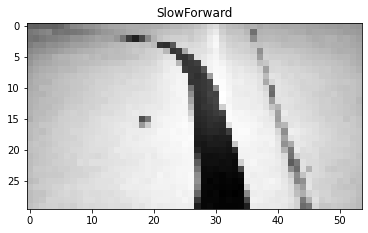

In [9]:
review_data (100)

In [16]:
    
def preview_dataset(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # number of histograms per raws & columns
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['motion'][i]} , {data['LMR'][i]} , {data['time-sec'][i]}") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

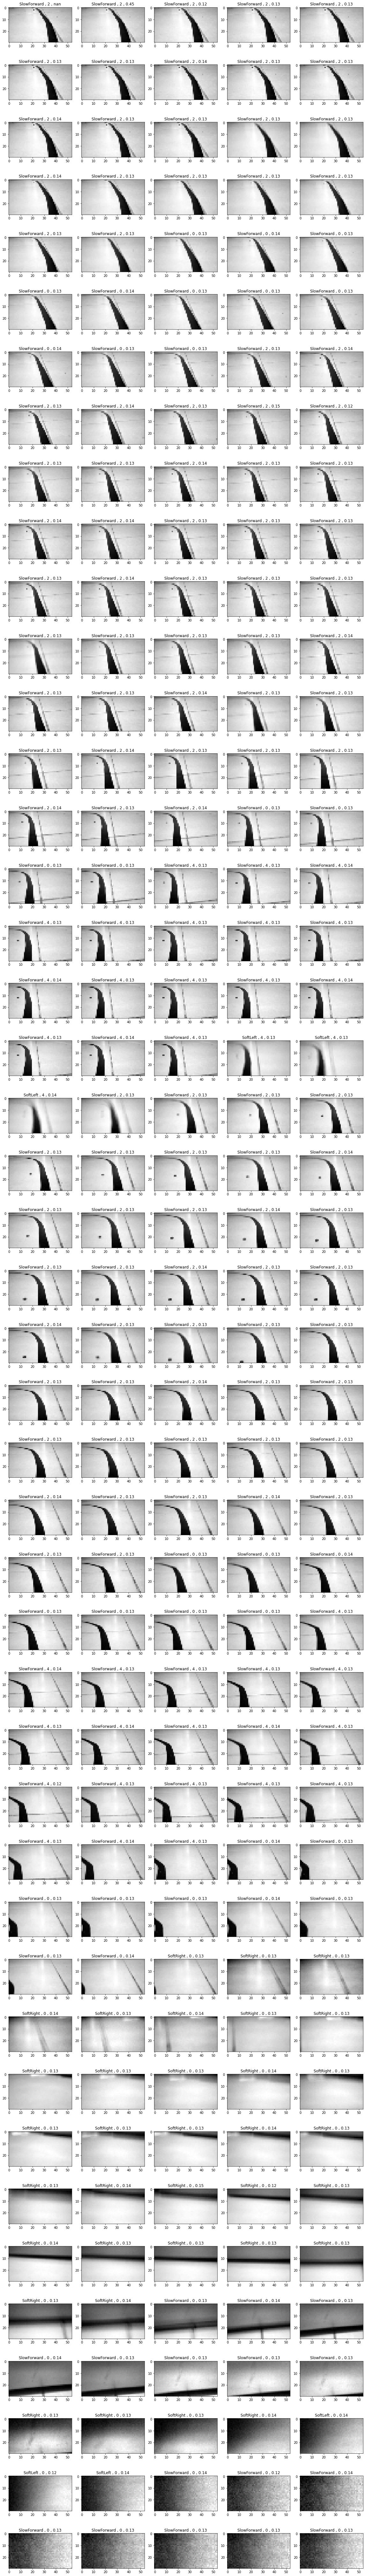

In [21]:
preview_dataset(data = data, 
                START_FRAME = 0, 
                END_FRAME = 225 )

In [ ]:
def review_data (row):
    # get the image by location (as json format)
    img_as_json = data['img'][row]

    # convert the json to nested list
    img_as_list = json.loads(img_as_json)

    # convert the nested list to np.array
    img = np.array(img_as_list)

    # show the image
    plt.imshow(img, cmap='gray')
    plt.title(data['motion'][row])
    plt.show()

## Setup to label images quickly

In [39]:
from IPython.display import display, clear_output

In [42]:
def labeling_dataset(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME

    dataset = data
    # create a new column in data
    dataset['labels'] = None

    # iterate through data to create histograms
    for i in range(START_FRAME,END_FRAME ):
        # get the image by location (as json format)
        img_as_json = dataset['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)
        # convert the nested list to np.array
        img = np.array(img_as_list)
        
        # show the image
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title(dataset['motion'][i])
        plt.show()
        #display(plt.gcf())
        plt.close()

        label = getpass.getpass("Add driving direction:")
        dataset.at[i, 'labels'] = int(label)

        # Clear the previous output to show the next image
        if i != END_FRAME - 1:
            clear_output(wait=True)
            
    
    return dataset

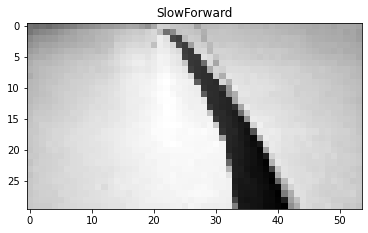

,motion,timestamp,i,LMR,model_prediction,img,time-sec,labels
0,SlowForward,2024-01-03 20:51:23.078752,0,2,0,"[[86, 87, 91, 72, 89, 104, 107, 110, 117, 122,...",NaN,0
1,SlowForward,2024-01-03 20:51:23.526859,1,2,0,"[[92, 96, 97, 83, 94, 99, 104, 109, 113, 119, ...",0.45,0
2,SlowForward,2024-01-03 20:51:23.643797,2,2,0,"[[93, 96, 102, 86, 95, 98, 106, 111, 116, 122,...",0.12,0
3,SlowForward,2024-01-03 20:51:23.773899,3,2,0,"[[86, 90, 94, 80, 90, 100, 106, 110, 113, 121,...",0.13,0
4,SlowForward,2024-01-03 20:51:23.907948,4,2,0,"[[90, 92, 94, 79, 92, 99, 109, 112, 117, 119, ...",0.13,0
...,...,...,...,...,...,...,...,...
220,SlowForward,2024-01-03 20:51:52.759799,220,0,0,"[[8, 8, 8, 8, 8, 8, 9, 8, 8, 11, 9, 10, 9, 10,...",0.13,None
221,SlowForward,2024-01-03 20:51:52.888477,221,0,0,"[[7, 7, 8, 10, 9, 8, 7, 9, 10, 10, 9, 9, 10, 1...",0.13,None
222,SlowForward,2024-01-03 20:51:53.021785,222,0,0,"[[7, 8, 8, 10, 9, 9, 9, 9, 10, 10, 11, 11, 10,...",0.13,None
223,SlowForward,2024-01-03 20:51:53.154578,223,0,0,"[[8, 7, 8, 7, 8, 9, 8, 9, 10, 8, 10, 10, 10, 9...",0.13,None


In [45]:
labeling_dataset(data = data, 
                 START_FRAME = 0, 
                 END_FRAME = 20 )